In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report,confusion_matrix
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

## Cargando Data


In [2]:
data = pd.read_csv('Airlines.csv')

# Creamos variable delay2 para mapear como variable categórica a Delay

data['delay2'] = data['Delay'].map({0: 'On Time', 1: 'Delayed'})
data

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,delay2
0,1,CO,269,SFO,IAH,3,15,205,1,Delayed
1,2,US,1558,PHX,CLT,3,15,222,1,Delayed
2,3,AA,2400,LAX,DFW,3,20,165,1,Delayed
3,4,AA,2466,SFO,DFW,3,20,195,1,Delayed
4,5,AS,108,ANC,SEA,3,30,202,0,On Time
...,...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0,On Time
539379,539380,FL,398,SEA,ATL,5,1439,305,0,On Time
539380,539381,FL,609,SFO,MKE,5,1439,255,0,On Time
539381,539382,UA,78,HNL,SFO,5,1439,313,1,Delayed


## Análisis Exploratorio

In [3]:
data.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.000000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.604461,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.000000,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [4]:
data.Flight.value_counts()

16      420
5       407
9       401
8       396
62      364
       ... 
7814      1
3573      1
4385      1
3292      1
6969      1
Name: Flight, Length: 6585, dtype: int64

delay2
Delayed    240264
On Time    299119
Name: delay2, dtype: int64


<BarContainer object of 2 artists>

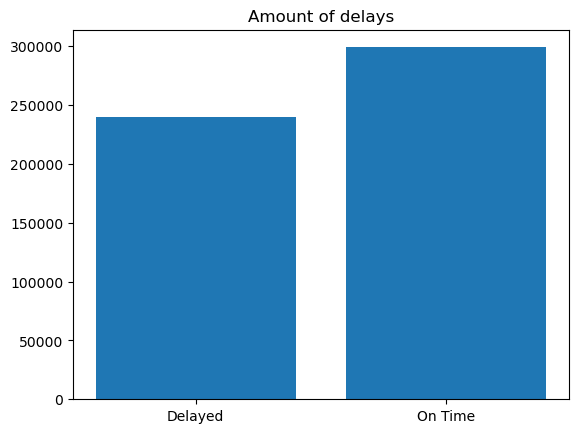

In [5]:
## Contando la cantidad de atrasos

delays_grouped = data['delay2'].groupby(data['delay2']).count()
print(delays_grouped)

plt.title("Amount of delays")
plt.bar(delays_grouped.keys(), delays_grouped)


In [6]:
## Creando dummies para contar cantidad de atrasos y salidas a tiempo.

delays_dummy = pd.get_dummies(data, columns=['delay2'])
delays_dummy

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,delay2_Delayed,delay2_On Time
0,1,CO,269,SFO,IAH,3,15,205,1,1,0
1,2,US,1558,PHX,CLT,3,15,222,1,1,0
2,3,AA,2400,LAX,DFW,3,20,165,1,1,0
3,4,AA,2466,SFO,DFW,3,20,195,1,1,0
4,5,AS,108,ANC,SEA,3,30,202,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0,0,1
539379,539380,FL,398,SEA,ATL,5,1439,305,0,0,1
539380,539381,FL,609,SFO,MKE,5,1439,255,0,0,1
539381,539382,UA,78,HNL,SFO,5,1439,313,1,1,0


Airline  delay2 
9E       Delayed     8226
         On Time    12460
AA       Delayed    17736
         On Time    27920
AS       Delayed     3892
         On Time     7579
B6       Delayed     8459
         On Time     9653
CO       Delayed    11957
         On Time     9161
DL       Delayed    27452
         On Time    33488
EV       Delayed    11255
         On Time    16728
F9       Delayed     2899
         On Time     3557
FL       Delayed     6275
         On Time    14552
HA       Delayed     1786
         On Time     3792
MQ       Delayed    12742
         On Time    23863
OH       Delayed     3502
         On Time     9128
OO       Delayed    22760
         On Time    27494
UA       Delayed     8946
         On Time    18673
US       Delayed    11591
         On Time    22909
WN       Delayed    65657
         On Time    28440
XE       Delayed    11795
         On Time    19331
YV       Delayed     3334
         On Time    10391
dtype: int64


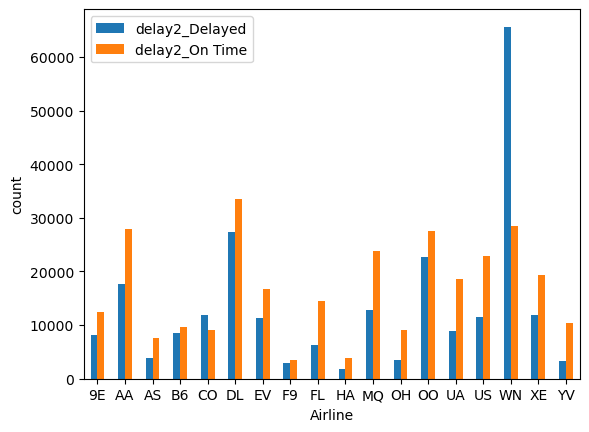

In [7]:
## Contando atrasos por aerolínea

delays_per_airline = data.groupby(['Airline', 'delay2']).size()
print(delays_per_airline)

dummy_grouped_airlines = delays_dummy.groupby(delays_dummy["Airline"]).agg({'delay2_Delayed':'sum','delay2_On Time':'sum'})

ax = dummy_grouped_airlines.plot.bar(rot=0)
ax.set_ylabel("count");

In [8]:
## Contando atrasos por aeropuerto de origen

delays_per_airport = data.groupby(['AirportFrom', 'delay2']).size()
delays_per_airport

dummy_grouped_airports = delays_dummy.groupby(delays_dummy["AirportFrom"]).agg({'delay2_Delayed':'sum','delay2_On Time':'sum'})
dummy_grouped_airports

,delay2_Delayed,delay2_On Time
AirportFrom,,
ABE,110.0,232.0
ABI,32.0,179.0
ABQ,1375.0,1424.0
ABR,1.0,1.0
ABY,22.0,65.0
...,...,...
VPS,210.0,423.0
WRG,18.0,41.0
XNA,317.0,811.0


In [9]:
## Contando datos nulos 

data.isna().sum().sum()

0

In [10]:
## Matriz de Correlación

data = data.drop(columns=['id', 'delay2'])

data.corr()

,Flight,DayOfWeek,Time,Length,Delay
Flight,1.000000,0.000416,-0.005750,-0.341481,-0.046175
DayOfWeek,0.000416,1.000000,0.001273,0.013397,-0.026199
Time,-0.005750,0.001273,1.000000,-0.020612,0.150454
Length,-0.341481,0.013397,-0.020612,1.000000,0.040489
Delay,-0.046175,-0.026199,0.150454,0.040489,1.000000


## Creando datasets de entrenamiento y de prueba

In [11]:
## Transformando variables categóricas a numéricas 

x = data[['Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length']]

x["Airline"] = x["Airline"].astype('category')
x["AirportFrom"] = x["AirportFrom"].astype('category')
x["AirportTo"] = x["AirportTo"].astype('category')

x["Airline_cat"] = x["Airline"].cat.codes
x["AirportFrom_cat"] = x["AirportFrom"].cat.codes
x["AirportTo_cat"] = x["AirportTo"].cat.codes

x = x.drop(columns=['Airline', 'AirportFrom', 'AirportTo'])
x

/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_5612/3933558557.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["Airline"] = x["Airline"].astype('category')
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_5612/3933558557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["AirportFrom"] = x["AirportFrom"].astype('category')
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_5612/3933558557.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Flight,DayOfWeek,Time,Length,Airline_cat,AirportFrom_cat,AirportTo_cat
0,269,3,15,205,4,253,135
1,1558,3,15,222,14,217,60
2,2400,3,20,165,1,154,80
3,2466,3,20,195,1,253,80
4,108,3,30,202,2,14,252
...,...,...,...,...,...,...,...
539378,178,5,1439,326,4,203,264
539379,398,5,1439,305,8,252,16
539380,609,5,1439,255,8,253,184
539381,78,5,1439,313,13,128,253


In [12]:
y = data['Delay']
y

0         1
1         1
2         1
3         1
4         0
         ..
539378    0
539379    0
539380    0
539381    1
539382    1
Name: Delay, Length: 539383, dtype: int64

In [13]:
## Armando datasets de prueba y entrenamiento

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

## Del set de entrenamiento, se desprenden 10000 datos para generar un dataset de validación

x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [14]:
print("Feature matrix:", x_train.shape)
print("Target matrix:", x_test.shape)
print("Feature matrix:", y_train.shape)
print("Target matrix:", y_test.shape)

Feature matrix: (421506, 7)
Target matrix: (107877, 7)
Feature matrix: (421506,)
Target matrix: (107877,)


## Construyendo el modelo

In [15]:
## Usando método Kudricky, con 4 capas, tenemos: 7 inputs, 15 para el HL1, 5 para el HL2 y 1 output

num_classes = 1
num_features = x_train.shape[1]
num_output = 1

num_layers_0 = 15
num_layers_1 = 5

epochs = 21
learning_rate = 0.0001
batch_size = 2048

In [16]:
## Armando las distintas capas

inputs = keras.Input(shape = (num_features,), name = "delays")
x1 = layers.Dense(num_layers_0, activation = "sigmoid", name = "dense_1")(inputs)
x2 = layers.Dense(num_layers_1, activation = "sigmoid", name = "dense_2")(x1)
outputs = layers.Dense(num_output, activation = "sigmoid", name = "predictions")(x2)

model = keras.Model(inputs = inputs, outputs = outputs)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-09-18 13:00:16.415301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-18 13:00:16.415403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
## Compilando el modelo

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    loss = keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = [keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.BinaryAccuracy()],
)

In [18]:
# Entrenando el modelo

training = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(x_val, y_val),
)

Epoch 1/21


2022-09-18 13:00:16.608843: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-18 13:00:16.838077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


206/206 [==============================] - 3s 11ms/step - loss: 0.7003 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_accuracy: 0.5541 - val_loss: 0.6936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.5598
Epoch 2/21
  1/206 [..............................] - ETA: 2s - loss: 0.7026 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_accuracy: 0.5400

2022-09-18 13:00:19.079740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


206/206 [==============================] - 2s 9ms/step - loss: 0.6935 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_accuracy: 0.5541 - val_loss: 0.6889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.5598
Epoch 3/21
206/206 [==============================] - 2s 9ms/step - loss: 0.6896 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_accuracy: 0.5541 - val_loss: 0.6864 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.5598
Epoch 4/21
206/206 [==============================] - 2s 10ms/step - loss: 0.6877 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_accuracy: 0.5541 - val_loss: 0.6853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.5598
Epoch 5/21
206/206 [==============================] - 2s 9ms/step - loss: 0.6866 - precision: 0.0000e+00 - recall: 0.0000e+00 - binary_accuracy: 0.5541 - val_loss: 0.6844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0

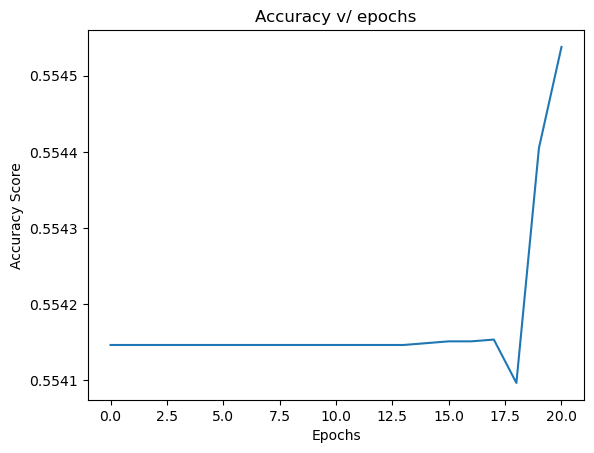

In [19]:
training.history['binary_accuracy']
training.epoch

plt.plot(training.epoch, training.history['binary_accuracy'])
plt.title('Accuracy v/ epochs')
plt.ylabel('Accuracy Score')
plt.xlabel('Epochs')
plt.show()

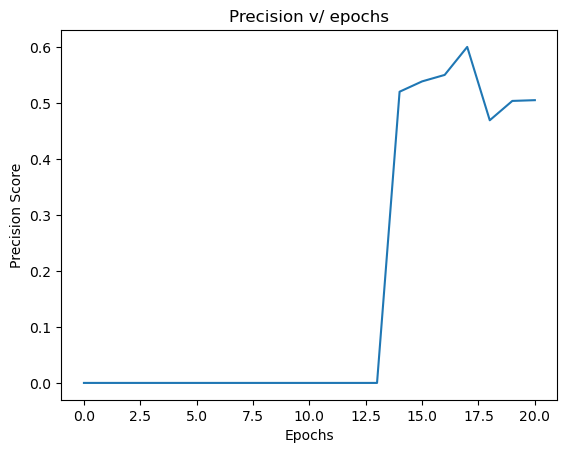

In [20]:
training.history['precision']
plt.plot(training.epoch, training.history['precision'])
plt.title('Precision v/ epochs')
plt.ylabel('Precision Score')
plt.xlabel('Epochs')
plt.show()

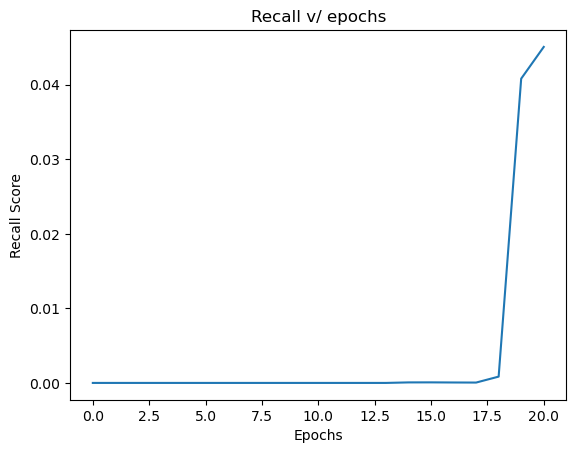

In [21]:
training.history['recall']
plt.plot(training.epoch, training.history['recall'])
plt.title('Recall v/ epochs')
plt.ylabel('Recall Score')
plt.xlabel('Epochs')
plt.show()

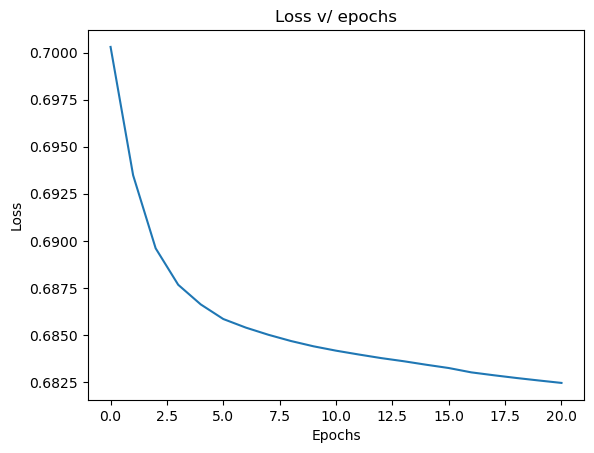

In [22]:
training.history['loss']
plt.plot(training.epoch, training.history['loss'])
plt.title('Loss v/ epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [23]:
## Evaluando el modelo

results = model.evaluate(x_test, y_test, batch_size = 2048)
print("test loss, test acc, test prec, test recall:", results)

53/53 [==============================] - 0s 7ms/step - loss: 0.6823 - precision: 0.5070 - recall: 0.0477 - binary_accuracy: 0.5563
test loss, test acc, test prec, test recall: [0.6822835206985474, 0.5069891214370728, 0.04767170175909996, 0.5562631487846375]


In [24]:
## Generando predicciones

predict_train = (model.predict(x_train) > 0.5).astype(int)
predict_test = (model.predict(x_test) > 0.5).astype(int)

   65/13173 [..............................] - ETA: 31s

2022-09-18 13:00:58.423513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3372/3372 [==============================] - 6s 2ms/step


In [25]:
predict_train, predict_test

(array([[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [0]]),
 array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]))

In [26]:
## Matriz de confusión para dataset de entrenamiento

print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[224771   8805]
 [179010   8920]]
              precision    recall  f1-score   support

           0       0.56      0.96      0.71    233576
           1       0.50      0.05      0.09    187930

    accuracy                           0.55    421506
   macro avg       0.53      0.50      0.40    421506
weighted avg       0.53      0.55      0.43    421506



In [27]:
## Matriz de confusión para dataset de prueba

print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

[[57723  2222]
 [45647  2285]]
              precision    recall  f1-score   support

           0       0.56      0.96      0.71     59945
           1       0.51      0.05      0.09     47932

    accuracy                           0.56    107877
   macro avg       0.53      0.51      0.40    107877
weighted avg       0.54      0.56      0.43    107877

